# Обучение Модели CV для классификации возраста

Цель - создание архитектуры модели CV и обучение ее для классификации возраста человека на фото

Данные - имеется размеченный набор фотографий, в каждой папке с нзванием соответствующего возраста находится набор фотографий. Сам набор данных взят с kaggle.
https://www.kaggle.com/datasets/frabbisw/facial-age

Загрузим все необходимые библиотеки и подключим видеокарту для ускорения вычисления.

In [1]:
import os
# Установка путей к CUDA 13.0
cuda_path = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.0'
os.environ['CUDA_PATH'] = cuda_path

# Добавление необходимых путей в PATH
cuda_bin = os.path.join(cuda_path, 'bin')
cuda_libnvvp = os.path.join(cuda_path, 'libnvvp')

# Добавляем пути в начало PATH для приоритета
os.environ['PATH'] = cuda_bin + os.pathsep + cuda_libnvvp + os.pathsep + os.environ['PATH']

print("Пути CUDA 13.0 установлены!")

import shutil
from PIL import Image
import tensorflow as tf

import torch
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Версия CUDA в PyTorch: {torch.version.cuda}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Имя устройства: {torch.cuda.get_device_name()}")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet50_Weights
from collections import Counter
import re
import time
from tqdm import tqdm
import gc
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Пути CUDA 13.0 установлены!
CUDA доступна: True
Версия CUDA в PyTorch: 12.1
Количество GPU: 1
Имя устройства: NVIDIA GeForce RTX 4070
Используется устройство: cuda


Первоначально имеется одна папка, в которой имеется около 100 папок с фотографиями. Необходимо распределить все эти папки на train, test, val в соотношении 0.8/0.1/0.1, но стоит учесть что некоторых фотографий в папках меньше 3, поэтому после распределения будут пустые папки.

In [3]:
source_data = 'face_age'
dest_base = 'data_split'

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Создаём папки train, val, test с подпапками классов
for split in ['train', 'val', 'test']:
    for i in range(1, 111):
        os.makedirs(os.path.join(dest_base, split, f'{i:03}'), exist_ok=True)

for class_num in range(1, 111):
    class_dir = f'{class_num:03}'
    source_class_path = os.path.join(source_data, class_dir)


    if not os.path.exists(source_class_path):
        print(f"Пропускаем класс {class_dir} — нет данных")
        continue
        
    files = os.listdir(source_class_path)
    random.shuffle(files)
    
    train_idx = int(train_ratio * len(files))
    val_idx = train_idx + int(val_ratio * len(files))
    
    train_files = files[:train_idx]
    val_files = files[train_idx:val_idx]
    test_files = files[val_idx:]
    
    # Копируем в train
    for f in train_files:
        src = os.path.join(source_class_path, f)
        dst = os.path.join(dest_base, 'train', class_dir, f)
        shutil.copy(src, dst)

    # Копируем в test
    for f in test_files:
        src = os.path.join(source_class_path, f)
        dst = os.path.join(dest_base, 'test', class_dir, f)
        shutil.copy(src, dst)
    
    # Копируем в val
    for f in val_files:
        src = os.path.join(source_class_path, f)
        dst = os.path.join(dest_base, 'val', class_dir, f)
        shutil.copy(src, dst)
    
    print(f"Класс {class_dir}: train={len(train_files)}, val={len(val_files)}")

print("Готово!")

Класс 001: train=889, val=111
Класс 002: train=380, val=47
Класс 003: train=227, val=28
Класс 004: train=208, val=26
Класс 005: train=144, val=18
Класс 006: train=91, val=11
Класс 007: train=100, val=12
Класс 008: train=188, val=23
Класс 009: train=127, val=15
Класс 010: train=112, val=14
Класс 011: train=50, val=6
Класс 012: train=84, val=10
Класс 013: train=60, val=7
Класс 014: train=109, val=13
Класс 015: train=114, val=14
Класс 016: train=169, val=21
Класс 017: train=82, val=10
Класс 018: train=144, val=18
Класс 019: train=46, val=5
Класс 020: train=82, val=10
Класс 021: train=108, val=13
Класс 022: train=111, val=13
Класс 023: train=73, val=9
Класс 024: train=152, val=19
Класс 025: train=124, val=15
Класс 026: train=223, val=27
Класс 027: train=100, val=12
Класс 028: train=116, val=14
Класс 029: train=120, val=15
Класс 030: train=87, val=10
Класс 031: train=77, val=9
Класс 032: train=112, val=14
Класс 033: train=36, val=4
Класс 034: train=69, val=8
Класс 035: train=96, val=12
Клас

Как и предполагалось есть множество пустых папок - пройдемся по всем папкам и удалим пустые.

In [4]:
def remove_all_empty_folders(root_path='data_split'):

    print(f"\n🧹 Рекурсивное удаление пустых папок в {root_path}...")
    
    deleted_count = 0
    for root, dirs, files in os.walk(root_path, topdown=False):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            
            try:
                dir_contents = os.listdir(dir_path)
                visible_contents = [f for f in dir_contents if not f.startswith('.')]
                
                if len(visible_contents) == 0:
                    shutil.rmtree(dir_path)
                    deleted_count += 1
                    print(f"🗑️  Удалена: {dir_path}")
            except Exception as e:
                print(f"⚠️  Ошибка при проверке {dir_path}: {e}")
    
    print(f"Удалено {deleted_count} пустых папок")

remove_all_empty_folders(root_path='data_split')


🧹 Рекурсивное удаление пустых папок в data_split...
🗑️  Удалена: data_split\test\094
🗑️  Удалена: data_split\test\097
🗑️  Удалена: data_split\test\098
🗑️  Удалена: data_split\test\102
🗑️  Удалена: data_split\test\103
🗑️  Удалена: data_split\test\104
🗑️  Удалена: data_split\test\105
🗑️  Удалена: data_split\test\106
🗑️  Удалена: data_split\test\107
🗑️  Удалена: data_split\test\108
🗑️  Удалена: data_split\test\109
🗑️  Удалена: data_split\train\091
🗑️  Удалена: data_split\train\094
🗑️  Удалена: data_split\train\097
🗑️  Удалена: data_split\train\098
🗑️  Удалена: data_split\train\101
🗑️  Удалена: data_split\train\102
🗑️  Удалена: data_split\train\103
🗑️  Удалена: data_split\train\104
🗑️  Удалена: data_split\train\105
🗑️  Удалена: data_split\train\106
🗑️  Удалена: data_split\train\107
🗑️  Удалена: data_split\train\108
🗑️  Удалена: data_split\train\109
🗑️  Удалена: data_split\val\083
🗑️  Удалена: data_split\val\087
🗑️  Удалена: data_split\val\091
🗑️  Удалена: data_split\val\093
🗑️  Удалена: d

Удалены 44 пустых папки, теперь остались только нужные папки с фотографией. Теперь пропишем пути для каждой папки, создадим трансормеры для данных и в итоге создадим датасеты фотографий.

In [5]:
BASE_PATH = r"C:\Users\User\Desktop\Нейронка для чая\data_split"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")
VAL_PATH = os.path.join(BASE_PATH, "val")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Изменение размера
    transforms.RandomHorizontalFlip(p=0.5), # Случайное отражение
    transforms.RandomRotation(10),          # Случайный поворот
    transforms.ToTensor(),                  # Конвертация в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Нормализация ImageNet
                         std=[0.229, 0.224, 0.225])
])


test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=VAL_PATH,
    transform=test_val_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_val_transform
)

Укажем батч в 256 и создадим DataLoader'ы для обучения модели.

In [6]:
BATCH_SIZE = 256
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True 
)

val_loader =DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Просмотрим некоторые примеры из обучающего набора данных, также укажим Label над фотографиями (реальный возраст num + 1).

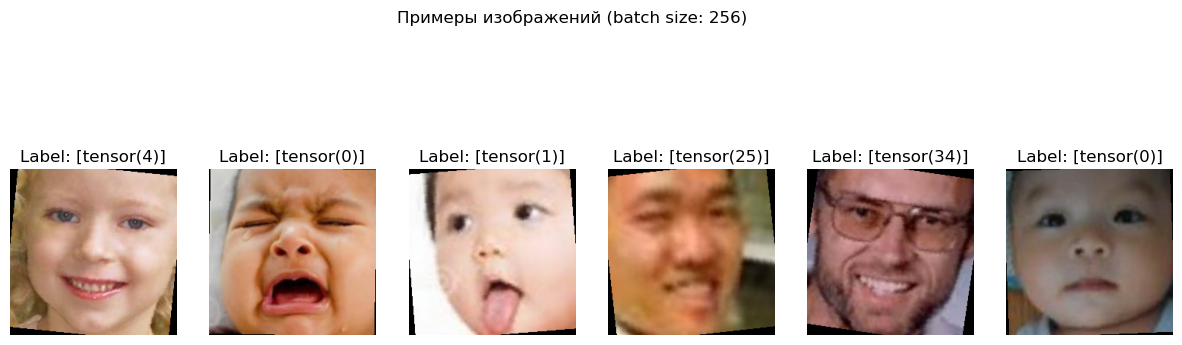

In [7]:
def show_batch_samples(loader, num_samples=6):
    """Показать несколько примеров из датасета"""
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        # Денормализация изображения
        img = images[i].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {[labels[i]]}")
        axes[i].axis('off')
    
    plt.suptitle(f"Примеры изображений (batch size: {BATCH_SIZE})")
    plt.show()

show_batch_samples(train_loader)

Фотографии правильно загружены и им присвоены правильные метки возраста, приступим к созданию архитектуры модели. Так как фотографий мало и в основном это люди до 10 лет, поэтому используем технику transfer learning и возьмем предобученную сеть resnet50 с весами модели, обученной на IMAGENET, последний слой сделаем блоком классификации с тремя полносвязными слоями, между которыми будут Dropout и BatchNorm1d.

In [8]:
class ResNet50FineTuned(nn.Module):
    def __init__(self):
        super(ResNet50FineTuned, self).__init__()
        
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        for name, param in self.backbone.named_parameters():
            if 'layer4' in name or 'fc' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False 

        
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 97)
        )
    
    def forward(self, x):
        return self.backbone(x)

    def unfreezze_cnn_layer(self):
        
        for name, param in self.backbone.named_parameters():
            if 'layer3' in name :
                param.requires_grad = True 
            else:
                param.requires_grad = False 

    def unfreezze_all_layer(self):
        
        for name, param in self.backbone.named_parameters():
            param.requires_grad = True 

model = ResNet50FineTuned().to(device)

Модель готова и перенесена на видеокарту, теперь составим функцию для рассчета метрики accuracy и обучении модели, как и в предущем блокноте.

In [9]:
def calculate_accuracy(outputs, labels):
    # Получаем индексы предсказанных классов (аргмакс по последнему измерению)
    _, preds = torch.max(outputs, dim=1)
    
    # Сравниваем предсказания с истинными метками
    correct = (preds == labels).float()  # тензор [batch_size] с 0 и 1
    
    # Вычисляем точность как среднее значение
    accuracy = correct.mean().item()
    
    return accuracy


In [10]:
def train_model_minimal(model, train_loader, val_loader, epochs=10, lr=0.0001):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Обучение на устройстве: {device}")
    print(f"Количество классов: {len(train_loader.dataset.classes)}")
    print(f"Эпох: {epochs}")
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # ========== ТРЕНИРОВКА ==========
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        # Прогресс-бар для тренировки
        train_pbar = tqdm(train_loader, 
                         desc=f'Эпоха {epoch+1}/{epochs} [Train]',
                         leave=True)
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Вычисляем точность
            with torch.no_grad():
                _, preds = torch.max(outputs, 1)
                batch_loss = loss.item()
                batch_correct = (preds == labels).sum().item()
                batch_total = images.size(0)
                batch_acc = batch_correct / batch_total
                
                train_loss += batch_loss * batch_total
                train_correct += batch_correct
                train_total += batch_total
                
                # Обновляем прогресс-бар
                train_pbar.set_postfix({
                    'loss': f'{batch_loss:.4f}',
                    'acc': f'{batch_acc:.3f}',
                    'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
                })
        
        # ========== ВАЛИДАЦИЯ ==========
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        # Прогресс-бар для валидации
        val_pbar = tqdm(val_loader, 
                       desc=f'Эпоха {epoch+1}/{epochs} [Val]',
                       leave=True)
        
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                batch_loss = loss.item()
                batch_correct = (preds == labels).sum().item()
                batch_total = images.size(0)
                batch_acc = batch_correct / batch_total
                
                val_loss += batch_loss * batch_total
                val_correct += batch_correct
                val_total += batch_total
                
                # Обновляем прогресс-бар
                val_pbar.set_postfix({
                    'loss': f'{batch_loss:.4f}',
                    'acc': f'{batch_acc:.3f}'
                })
        
        # Средние метрики для эпохи
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        
        # Сохраняем историю
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        epoch_time = time.time() - start_time
        
        # Вывод итогов эпохи
        print(f"\n{'='*50}")
        print(f"Эпоха {epoch+1}/{epochs} | Время: {epoch_time:.1f}s")
        print(f"{'='*50}")
        print(f"Train: Loss = {epoch_train_loss:.4f}, Accuracy = {epoch_train_acc:.4f} ({train_correct}/{train_total})")
        print(f"Val:   Loss = {epoch_val_loss:.4f}, Accuracy = {epoch_val_acc:.4f} ({val_correct}/{val_total})")
        
        # Сохраняем лучшую модель
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
                'train_acc': epoch_train_acc,
                'val_acc': epoch_val_acc,
                'classes': train_loader.dataset.classes
            }, 'best_model.pth')
            print(f"✓ Сохранена лучшая модель (loss: {best_val_loss:.4f})")
    
    # Итоги обучения
    print(f"\n{'='*60}")
    print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print(f"{'='*60}")
    print(f"Лучшая точность валидации: {max(history['val_acc']):.4f}")
    print(f"Лучший loss валидации: {best_val_loss:.4f}")
    print(f"Финальная точность валидации: {history['val_acc'][-1]:.4f}")
    
    return history

Все готово! Приступим к обучении модели, возьмем 30 эпох и lr = 0.0001 для начала

In [11]:
history = train_model_minimal(model, train_loader, val_loader, 30, lr=0.0001)

Обучение на устройстве: cuda
Количество классов: 97
Эпох: 30


Эпоха 1/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=4.5434, acc=0.025]



Эпоха 1/30 | Время: 46.0s
Train: Loss = 4.2474, Accuracy = 0.1000 (947/9472)
Val:   Loss = 3.9310, Accuracy = 0.1376 (309/2245)
✓ Сохранена лучшая модель (loss: 3.9310)


Эпоха 2/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s, loss=4.5481, acc=0.015]



Эпоха 2/30 | Время: 46.0s
Train: Loss = 3.7444, Accuracy = 0.1661 (1573/9472)
Val:   Loss = 3.6175, Accuracy = 0.1697 (381/2245)
✓ Сохранена лучшая модель (loss: 3.6175)


Эпоха 3/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=4.4952, acc=0.015]



Эпоха 3/30 | Время: 45.3s
Train: Loss = 3.4716, Accuracy = 0.1895 (1795/9472)
Val:   Loss = 3.4772, Accuracy = 0.1800 (404/2245)
✓ Сохранена лучшая модель (loss: 3.4772)


Эпоха 4/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=4.4690, acc=0.015]



Эпоха 4/30 | Время: 45.7s
Train: Loss = 3.2788, Accuracy = 0.2089 (1979/9472)
Val:   Loss = 3.2406, Accuracy = 0.2080 (467/2245)
✓ Сохранена лучшая модель (loss: 3.2406)


Эпоха 5/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=4.3939, acc=0.015]



Эпоха 5/30 | Время: 45.7s
Train: Loss = 3.1188, Accuracy = 0.2300 (2179/9472)
Val:   Loss = 3.1131, Accuracy = 0.2187 (491/2245)
✓ Сохранена лучшая модель (loss: 3.1131)


Эпоха 6/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.15it/s, loss=4.3568, acc=0.020]



Эпоха 6/30 | Время: 45.9s
Train: Loss = 2.9934, Accuracy = 0.2401 (2274/9472)
Val:   Loss = 2.9990, Accuracy = 0.2298 (516/2245)
✓ Сохранена лучшая модель (loss: 2.9990)


Эпоха 7/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=4.2775, acc=0.020]



Эпоха 7/30 | Время: 45.4s
Train: Loss = 2.8794, Accuracy = 0.2616 (2478/9472)
Val:   Loss = 2.9557, Accuracy = 0.2339 (525/2245)
✓ Сохранена лучшая модель (loss: 2.9557)


Эпоха 8/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=4.3691, acc=0.015]



Эпоха 8/30 | Время: 45.9s
Train: Loss = 2.7701, Accuracy = 0.2803 (2655/9472)
Val:   Loss = 2.7880, Accuracy = 0.2682 (602/2245)
✓ Сохранена лучшая модель (loss: 2.7880)


Эпоха 9/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=4.1270, acc=0.030]



Эпоха 9/30 | Время: 46.0s
Train: Loss = 2.6597, Accuracy = 0.2966 (2809/9472)
Val:   Loss = 2.7270, Accuracy = 0.2704 (607/2245)
✓ Сохранена лучшая модель (loss: 2.7270)


Эпоха 10/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=4.1814, acc=0.030]



Эпоха 10/30 | Время: 45.7s
Train: Loss = 2.5817, Accuracy = 0.3064 (2902/9472)
Val:   Loss = 2.6380, Accuracy = 0.2802 (629/2245)
✓ Сохранена лучшая модель (loss: 2.6380)


Эпоха 11/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=4.0342, acc=0.036]



Эпоха 11/30 | Время: 45.5s
Train: Loss = 2.5030, Accuracy = 0.3223 (3053/9472)
Val:   Loss = 2.5169, Accuracy = 0.3105 (697/2245)
✓ Сохранена лучшая модель (loss: 2.5169)


Эпоха 12/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.20it/s, loss=3.9322, acc=0.056]



Эпоха 12/30 | Время: 44.9s
Train: Loss = 2.4027, Accuracy = 0.3511 (3326/9472)
Val:   Loss = 2.4331, Accuracy = 0.3292 (739/2245)
✓ Сохранена лучшая модель (loss: 2.4331)


Эпоха 13/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.9466, acc=0.056]



Эпоха 13/30 | Время: 46.1s
Train: Loss = 2.3370, Accuracy = 0.3558 (3370/9472)
Val:   Loss = 2.3865, Accuracy = 0.3412 (766/2245)
✓ Сохранена лучшая модель (loss: 2.3865)


Эпоха 14/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.8351, acc=0.086]



Эпоха 14/30 | Время: 45.4s
Train: Loss = 2.2558, Accuracy = 0.3833 (3631/9472)
Val:   Loss = 2.2874, Accuracy = 0.3679 (826/2245)
✓ Сохранена лучшая модель (loss: 2.2874)


Эпоха 15/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=3.7885, acc=0.056]



Эпоха 15/30 | Время: 45.8s
Train: Loss = 2.1756, Accuracy = 0.3978 (3768/9472)
Val:   Loss = 2.3485, Accuracy = 0.3318 (745/2245)


Эпоха 16/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.7550, acc=0.102]



Эпоха 16/30 | Время: 46.4s
Train: Loss = 2.1124, Accuracy = 0.4122 (3904/9472)
Val:   Loss = 2.1399, Accuracy = 0.4053 (910/2245)
✓ Сохранена лучшая модель (loss: 2.1399)


Эпоха 17/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.8540, acc=0.076]



Эпоха 17/30 | Время: 45.8s
Train: Loss = 2.0341, Accuracy = 0.4321 (4093/9472)
Val:   Loss = 2.1878, Accuracy = 0.4196 (942/2245)


Эпоха 18/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=3.6753, acc=0.102]



Эпоха 18/30 | Время: 45.2s
Train: Loss = 1.9787, Accuracy = 0.4474 (4238/9472)
Val:   Loss = 2.0255, Accuracy = 0.4352 (977/2245)
✓ Сохранена лучшая модель (loss: 2.0255)


Эпоха 19/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.5995, acc=0.107]



Эпоха 19/30 | Время: 45.6s
Train: Loss = 1.9010, Accuracy = 0.4671 (4424/9472)
Val:   Loss = 1.9599, Accuracy = 0.4419 (992/2245)
✓ Сохранена лучшая модель (loss: 1.9599)


Эпоха 20/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=3.6323, acc=0.112]



Эпоха 20/30 | Время: 46.1s
Train: Loss = 1.8382, Accuracy = 0.4838 (4583/9472)
Val:   Loss = 1.9371, Accuracy = 0.4530 (1017/2245)
✓ Сохранена лучшая модель (loss: 1.9371)


Эпоха 21/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.5683, acc=0.132]



Эпоха 21/30 | Время: 45.5s
Train: Loss = 1.7814, Accuracy = 0.5013 (4748/9472)
Val:   Loss = 1.8511, Accuracy = 0.4931 (1107/2245)
✓ Сохранена лучшая модель (loss: 1.8511)


Эпоха 22/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.4560, acc=0.147]



Эпоха 22/30 | Время: 45.7s
Train: Loss = 1.7236, Accuracy = 0.5210 (4935/9472)
Val:   Loss = 1.7956, Accuracy = 0.5247 (1178/2245)
✓ Сохранена лучшая модель (loss: 1.7956)


Эпоха 23/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.4671, acc=0.147]



Эпоха 23/30 | Время: 45.7s
Train: Loss = 1.6635, Accuracy = 0.5432 (5145/9472)
Val:   Loss = 1.7242, Accuracy = 0.5216 (1171/2245)
✓ Сохранена лучшая модель (loss: 1.7242)


Эпоха 24/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.5482, acc=0.157]



Эпоха 24/30 | Время: 45.9s
Train: Loss = 1.5944, Accuracy = 0.5583 (5288/9472)
Val:   Loss = 1.7712, Accuracy = 0.5216 (1171/2245)


Эпоха 25/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=3.5562, acc=0.147]



Эпоха 25/30 | Время: 45.3s
Train: Loss = 1.5583, Accuracy = 0.5668 (5369/9472)
Val:   Loss = 1.6519, Accuracy = 0.5648 (1268/2245)
✓ Сохранена лучшая модель (loss: 1.6519)


Эпоха 26/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.3924, acc=0.193]



Эпоха 26/30 | Время: 45.7s
Train: Loss = 1.4938, Accuracy = 0.5928 (5615/9472)
Val:   Loss = 1.6053, Accuracy = 0.5728 (1286/2245)
✓ Сохранена лучшая модель (loss: 1.6053)


Эпоха 27/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.2456, acc=0.193]



Эпоха 27/30 | Время: 45.8s
Train: Loss = 1.4316, Accuracy = 0.6052 (5732/9472)
Val:   Loss = 1.4825, Accuracy = 0.6111 (1372/2245)
✓ Сохранена лучшая модель (loss: 1.4825)


Эпоха 28/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.3099, acc=0.234]



Эпоха 28/30 | Время: 45.8s
Train: Loss = 1.3777, Accuracy = 0.6192 (5865/9472)
Val:   Loss = 1.4689, Accuracy = 0.6223 (1397/2245)
✓ Сохранена лучшая модель (loss: 1.4689)


Эпоха 29/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=3.4366, acc=0.162]



Эпоха 29/30 | Время: 46.0s
Train: Loss = 1.3293, Accuracy = 0.6403 (6065/9472)
Val:   Loss = 1.4750, Accuracy = 0.6192 (1390/2245)


Эпоха 30/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.0485, acc=0.228]



Эпоха 30/30 | Время: 47.0s
Train: Loss = 1.2787, Accuracy = 0.6501 (6158/9472)
Val:   Loss = 1.3320, Accuracy = 0.6570 (1475/2245)
✓ Сохранена лучшая модель (loss: 1.3320)

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая точность валидации: 0.6570
Лучший loss валидации: 1.3320
Финальная точность валидации: 0.6570


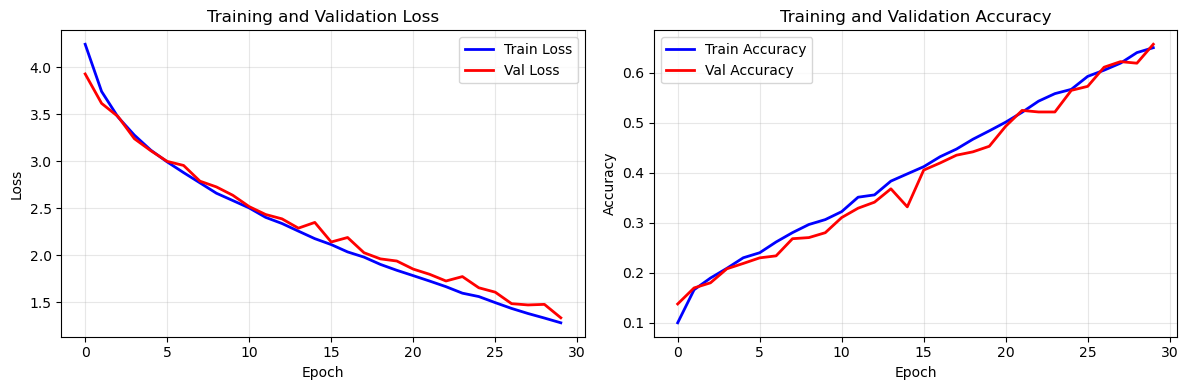

Final Train Loss: 1.2787
Final Val Loss: 1.3320
Final Train Accuracy: 0.6501
Final Val Accuracy: 0.6570
Best Val Accuracy: 0.6570


In [14]:
train_losses, val_losses, train_accs, val_accs = history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc']
    
    # Создаем subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # График потерь
ax1.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
    
    # График точности
ax2.plot(train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, 'r-', label='Val Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()
    
    # Вывод финальных результатов
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Val Accuracy: {val_accs[-1]:.4f}")
print(f"Best Val Accuracy: {max(val_accs):.4f}")

Обучение прошло отлично - метрика выросла с 0.15 до 0.65, но модель не достигла своего переобучения, поэтому продолжим его еще на 30 эпохах, lr оставим тем же.

In [15]:
history_2 = train_model_minimal(model, train_loader, val_loader, 30, lr=0.0001)

Обучение на устройстве: cuda
Количество классов: 97
Эпох: 30


Эпоха 1/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=3.1686, acc=0.218]



Эпоха 1/30 | Время: 45.8s
Train: Loss = 1.2301, Accuracy = 0.6631 (6281/9472)
Val:   Loss = 1.3146, Accuracy = 0.6597 (1481/2245)
✓ Сохранена лучшая модель (loss: 1.3146)


Эпоха 2/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=3.1713, acc=0.269]



Эпоха 2/30 | Время: 45.8s
Train: Loss = 1.1484, Accuracy = 0.6927 (6561/9472)
Val:   Loss = 1.3292, Accuracy = 0.6521 (1464/2245)


Эпоха 3/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=3.0128, acc=0.279]



Эпоха 3/30 | Время: 46.1s
Train: Loss = 1.0786, Accuracy = 0.7079 (6705/9472)
Val:   Loss = 1.1833, Accuracy = 0.6953 (1561/2245)
✓ Сохранена лучшая модель (loss: 1.1833)


Эпоха 4/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=3.1440, acc=0.244]



Эпоха 4/30 | Время: 45.9s
Train: Loss = 1.0391, Accuracy = 0.7224 (6843/9472)
Val:   Loss = 1.1349, Accuracy = 0.7073 (1588/2245)
✓ Сохранена лучшая модель (loss: 1.1349)


Эпоха 5/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=2.9753, acc=0.325]



Эпоха 5/30 | Время: 45.7s
Train: Loss = 0.9999, Accuracy = 0.7326 (6939/9472)
Val:   Loss = 1.0895, Accuracy = 0.7323 (1644/2245)
✓ Сохранена лучшая модель (loss: 1.0895)


Эпоха 6/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.7901, acc=0.335]



Эпоха 6/30 | Время: 45.7s
Train: Loss = 0.9295, Accuracy = 0.7550 (7151/9472)
Val:   Loss = 0.9968, Accuracy = 0.7501 (1684/2245)
✓ Сохранена лучшая модель (loss: 0.9968)


Эпоха 7/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.9762, acc=0.299]



Эпоха 7/30 | Время: 45.9s
Train: Loss = 0.8885, Accuracy = 0.7649 (7245/9472)
Val:   Loss = 1.0309, Accuracy = 0.7501 (1684/2245)


Эпоха 8/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.9369, acc=0.325]



Эпоха 8/30 | Время: 45.6s
Train: Loss = 0.8465, Accuracy = 0.7809 (7397/9472)
Val:   Loss = 0.9915, Accuracy = 0.7519 (1688/2245)
✓ Сохранена лучшая модель (loss: 0.9915)


Эпоха 9/30 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.8885, acc=0.345]



Эпоха 9/30 | Время: 45.7s
Train: Loss = 0.8071, Accuracy = 0.7925 (7507/9472)
Val:   Loss = 1.0037, Accuracy = 0.7523 (1689/2245)


Эпоха 10/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.7095, acc=0.421]



Эпоха 10/30 | Время: 45.4s
Train: Loss = 0.7624, Accuracy = 0.8101 (7673/9472)
Val:   Loss = 0.8674, Accuracy = 0.7906 (1775/2245)
✓ Сохранена лучшая модель (loss: 0.8674)


Эпоха 11/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.13it/s, loss=2.6913, acc=0.467]



Эпоха 11/30 | Время: 46.1s
Train: Loss = 0.7054, Accuracy = 0.8223 (7789/9472)
Val:   Loss = 0.8320, Accuracy = 0.8094 (1817/2245)
✓ Сохранена лучшая модель (loss: 0.8320)


Эпоха 12/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.7080, acc=0.442]



Эпоха 12/30 | Время: 45.8s
Train: Loss = 0.6624, Accuracy = 0.8369 (7927/9472)
Val:   Loss = 0.8153, Accuracy = 0.8134 (1826/2245)
✓ Сохранена лучшая модель (loss: 0.8153)


Эпоха 13/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.4869, acc=0.487]



Эпоха 13/30 | Время: 45.8s
Train: Loss = 0.6101, Accuracy = 0.8543 (8092/9472)
Val:   Loss = 0.7341, Accuracy = 0.8535 (1916/2245)
✓ Сохранена лучшая модель (loss: 0.7341)


Эпоха 14/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.7129, acc=0.442]



Эпоха 14/30 | Время: 45.8s
Train: Loss = 0.5685, Accuracy = 0.8666 (8208/9472)
Val:   Loss = 0.7865, Accuracy = 0.8192 (1839/2245)


Эпоха 15/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.5819, acc=0.467]



Эпоха 15/30 | Время: 45.9s
Train: Loss = 0.5380, Accuracy = 0.8766 (8303/9472)
Val:   Loss = 0.7231, Accuracy = 0.8392 (1884/2245)
✓ Сохранена лучшая модель (loss: 0.7231)


Эпоха 16/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.4685, acc=0.528]



Эпоха 16/30 | Время: 45.8s
Train: Loss = 0.5161, Accuracy = 0.8776 (8313/9472)
Val:   Loss = 0.7103, Accuracy = 0.8441 (1895/2245)
✓ Сохранена лучшая модель (loss: 0.7103)


Эпоха 17/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.5458, acc=0.513]


Эпоха 17/30 | Время: 45.7s
Train: Loss = 0.4709, Accuracy = 0.8919 (8448/9472)
Val:   Loss = 0.6478, Accuracy = 0.8633 (1938/2245)


✓ Сохранена лучшая модель (loss: 0.6478)


Эпоха 18/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.4818, acc=0.538]



Эпоха 18/30 | Время: 45.8s
Train: Loss = 0.4493, Accuracy = 0.8982 (8508/9472)
Val:   Loss = 0.6744, Accuracy = 0.8535 (1916/2245)


Эпоха 19/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=2.5848, acc=0.497]



Эпоха 19/30 | Время: 45.8s
Train: Loss = 0.4354, Accuracy = 0.9000 (8525/9472)
Val:   Loss = 0.6176, Accuracy = 0.8744 (1963/2245)
✓ Сохранена лучшая модель (loss: 0.6176)


Эпоха 20/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.5064, acc=0.543]



Эпоха 20/30 | Время: 45.6s
Train: Loss = 0.4012, Accuracy = 0.9110 (8629/9472)
Val:   Loss = 0.6202, Accuracy = 0.8713 (1956/2245)


Эпоха 21/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.5223, acc=0.553]



Эпоха 21/30 | Время: 45.7s
Train: Loss = 0.3662, Accuracy = 0.9220 (8733/9472)
Val:   Loss = 0.5683, Accuracy = 0.8913 (2001/2245)
✓ Сохранена лучшая модель (loss: 0.5683)


Эпоха 22/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.3851, acc=0.589]



Эпоха 22/30 | Время: 45.7s
Train: Loss = 0.3441, Accuracy = 0.9255 (8766/9472)
Val:   Loss = 0.5635, Accuracy = 0.8927 (2004/2245)
✓ Сохранена лучшая модель (loss: 0.5635)


Эпоха 23/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.4144, acc=0.584]



Эпоха 23/30 | Время: 45.6s
Train: Loss = 0.3143, Accuracy = 0.9327 (8835/9472)
Val:   Loss = 0.5657, Accuracy = 0.8895 (1997/2245)


Эпоха 24/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.3082, acc=0.629]



Эпоха 24/30 | Время: 45.6s
Train: Loss = 0.3071, Accuracy = 0.9338 (8845/9472)
Val:   Loss = 0.5161, Accuracy = 0.9096 (2042/2245)
✓ Сохранена лучшая модель (loss: 0.5161)


Эпоха 25/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.3319, acc=0.619]



Эпоха 25/30 | Время: 46.0s
Train: Loss = 0.2855, Accuracy = 0.9408 (8911/9472)
Val:   Loss = 0.5190, Accuracy = 0.9024 (2026/2245)


Эпоха 26/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=2.2906, acc=0.629]



Эпоха 26/30 | Время: 45.6s
Train: Loss = 0.2598, Accuracy = 0.9470 (8970/9472)
Val:   Loss = 0.5098, Accuracy = 0.9082 (2039/2245)
✓ Сохранена лучшая модель (loss: 0.5098)


Эпоха 27/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.3512, acc=0.589]



Эпоха 27/30 | Время: 45.8s
Train: Loss = 0.2504, Accuracy = 0.9481 (8980/9472)
Val:   Loss = 0.5272, Accuracy = 0.9029 (2027/2245)


Эпоха 28/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.3425, acc=0.604]



Эпоха 28/30 | Время: 45.4s
Train: Loss = 0.2355, Accuracy = 0.9546 (9042/9472)
Val:   Loss = 0.5156, Accuracy = 0.9078 (2038/2245)


Эпоха 29/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.3201, acc=0.629]



Эпоха 29/30 | Время: 45.6s
Train: Loss = 0.2151, Accuracy = 0.9572 (9067/9472)
Val:   Loss = 0.5067, Accuracy = 0.9091 (2041/2245)
✓ Сохранена лучшая модель (loss: 0.5067)


Эпоха 30/30 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.3499, acc=0.624]



Эпоха 30/30 | Время: 45.7s
Train: Loss = 0.2071, Accuracy = 0.9596 (9089/9472)
Val:   Loss = 0.4985, Accuracy = 0.9145 (2053/2245)
✓ Сохранена лучшая модель (loss: 0.4985)

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая точность валидации: 0.9145
Лучший loss валидации: 0.4985
Финальная точность валидации: 0.9145


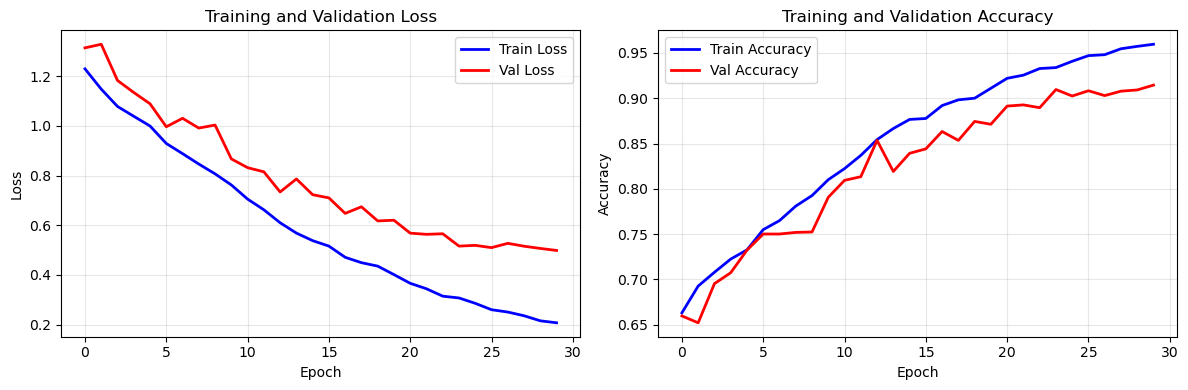

Final Train Loss: 0.2071
Final Val Loss: 0.4985
Final Train Accuracy: 0.9596
Final Val Accuracy: 0.9145
Best Val Accuracy: 0.9145


In [16]:
train_losses, val_losses, train_accs, val_accs = history_2['train_loss'], history_2['val_loss'], history_2['train_acc'], history_2['val_acc']
    
    # Создаем subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # График потерь
ax1.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
    
    # График точности
ax2.plot(train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, 'r-', label='Val Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()
    
    # Вывод финальных результатов
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Val Accuracy: {val_accs[-1]:.4f}")
print(f"Best Val Accuracy: {max(val_accs):.4f}")


Модель стала гораздо лучше и начали проявляться первые признаки переобучения. Заметно что val_loss стала более пологой, но есть еще потенциал к обучению модели, поэтому продолжим обучении, но на меньшем числе эпох.

In [17]:
history_3 = train_model_minimal(model, train_loader, val_loader, 15, lr=0.0001)

Обучение на устройстве: cuda
Количество классов: 97
Эпох: 15


Эпоха 1/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.3480, acc=0.635]



Эпоха 1/15 | Время: 46.2s
Train: Loss = 0.2194, Accuracy = 0.9565 (9060/9472)
Val:   Loss = 0.4982, Accuracy = 0.9163 (2057/2245)
✓ Сохранена лучшая модель (loss: 0.4982)


Эпоха 2/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.2393, acc=0.640]



Эпоха 2/15 | Время: 45.7s
Train: Loss = 0.1950, Accuracy = 0.9606 (9099/9472)
Val:   Loss = 0.4830, Accuracy = 0.9149 (2054/2245)
✓ Сохранена лучшая модель (loss: 0.4830)


Эпоха 3/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.4022, acc=0.650]



Эпоха 3/15 | Время: 45.7s
Train: Loss = 0.1918, Accuracy = 0.9600 (9093/9472)
Val:   Loss = 0.4962, Accuracy = 0.9145 (2053/2245)


Эпоха 4/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.2881, acc=0.645]



Эпоха 4/15 | Время: 45.5s
Train: Loss = 0.1786, Accuracy = 0.9628 (9120/9472)
Val:   Loss = 0.4811, Accuracy = 0.9176 (2060/2245)
✓ Сохранена лучшая модель (loss: 0.4811)


Эпоха 5/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.3856, acc=0.635]



Эпоха 5/15 | Время: 45.9s
Train: Loss = 0.1738, Accuracy = 0.9634 (9125/9472)
Val:   Loss = 0.4978, Accuracy = 0.9149 (2054/2245)


Эпоха 6/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.4235, acc=0.650]



Эпоха 6/15 | Время: 45.7s
Train: Loss = 0.1628, Accuracy = 0.9668 (9158/9472)
Val:   Loss = 0.4973, Accuracy = 0.9198 (2065/2245)


Эпоха 7/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.14it/s, loss=2.4143, acc=0.650]



Эпоха 7/15 | Время: 45.9s
Train: Loss = 0.1575, Accuracy = 0.9671 (9160/9472)
Val:   Loss = 0.4930, Accuracy = 0.9167 (2058/2245)


Эпоха 8/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.16it/s, loss=2.6028, acc=0.594]



Эпоха 8/15 | Время: 45.8s
Train: Loss = 0.1507, Accuracy = 0.9679 (9168/9472)
Val:   Loss = 0.5731, Accuracy = 0.8958 (2011/2245)


Эпоха 9/15 [Val]: 100%|██████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s, loss=2.4406, acc=0.645]



Эпоха 9/15 | Время: 45.2s
Train: Loss = 0.1398, Accuracy = 0.9710 (9197/9472)
Val:   Loss = 0.4845, Accuracy = 0.9194 (2064/2245)


Эпоха 10/15 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.4342, acc=0.635]



Эпоха 10/15 | Время: 45.5s
Train: Loss = 0.1360, Accuracy = 0.9714 (9201/9472)
Val:   Loss = 0.4797, Accuracy = 0.9189 (2063/2245)
✓ Сохранена лучшая модель (loss: 0.4797)


Эпоха 11/15 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.4547, acc=0.655]



Эпоха 11/15 | Время: 45.7s
Train: Loss = 0.1392, Accuracy = 0.9699 (9187/9472)
Val:   Loss = 0.5091, Accuracy = 0.9163 (2057/2245)


Эпоха 12/15 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.18it/s, loss=2.4718, acc=0.640]



Эпоха 12/15 | Время: 45.8s
Train: Loss = 0.1264, Accuracy = 0.9739 (9225/9472)
Val:   Loss = 0.4788, Accuracy = 0.9198 (2065/2245)
✓ Сохранена лучшая модель (loss: 0.4788)


Эпоха 13/15 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.14it/s, loss=2.5001, acc=0.655]



Эпоха 13/15 | Время: 46.1s
Train: Loss = 0.1264, Accuracy = 0.9731 (9217/9472)
Val:   Loss = 0.4886, Accuracy = 0.9163 (2057/2245)


Эпоха 14/15 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.4840, acc=0.655]



Эпоха 14/15 | Время: 47.8s
Train: Loss = 0.1245, Accuracy = 0.9728 (9214/9472)
Val:   Loss = 0.4830, Accuracy = 0.9207 (2067/2245)


Эпоха 15/15 [Val]: 100%|█████████████████████████████████████████| 9/9 [00:07<00:00,  1.17it/s, loss=2.6146, acc=0.645]


Эпоха 15/15 | Время: 45.9s
Train: Loss = 0.1182, Accuracy = 0.9726 (9212/9472)
Val:   Loss = 0.4979, Accuracy = 0.9163 (2057/2245)

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая точность валидации: 0.9207
Лучший loss валидации: 0.4788
Финальная точность валидации: 0.9163


Вот теперь модель достигла своего максимума, лучшая метрика 0.92 на валадационной выборке, загрузим лучшую модель и проверим модель на тестовой выборке.

In [18]:
def load_model_for_training(checkpoint_path, model_class):

    # Загружаем чекпоинт
    checkpoint = torch.load(checkpoint_path)
    
    # Создаем модель той же архитектуры
    model = model_class()
    
    # Загружаем веса модели
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Создаем оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Загружаем состояние оптимизатора
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Информация из чекпоинта
    epoch = checkpoint.get('epoch', 0)
    train_loss = checkpoint.get('train_loss', 0)
    val_loss = checkpoint.get('val_loss', 0)
    train_acc = checkpoint.get('train_acc', 0)
    val_acc = checkpoint.get('val_acc', 0)
    classes = checkpoint.get('classes', [])
    
    print(f"Модель загружена из: {checkpoint_path}")
    print(f"Эпоха: {epoch}")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")
    
    return model, optimizer, checkpoint



In [20]:
best_model, opt, check = load_model_for_training('best_model.pth', ResNet50FineTuned)

Модель загружена из: best_model.pth
Эпоха: 11
Val loss: 0.4788, Val accuracy: 0.9198


In [22]:
best_model = best_model.to(device)
best_model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = best_model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9329


На тестовой выборке метрика accuracy состовляет 0.9329! Результат превзошел результат на валидационной выборке. Создадим еще один даталоадер для просмотра результатов работы модели, ну и логично создадим функцию для просмотра результатов.

In [26]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

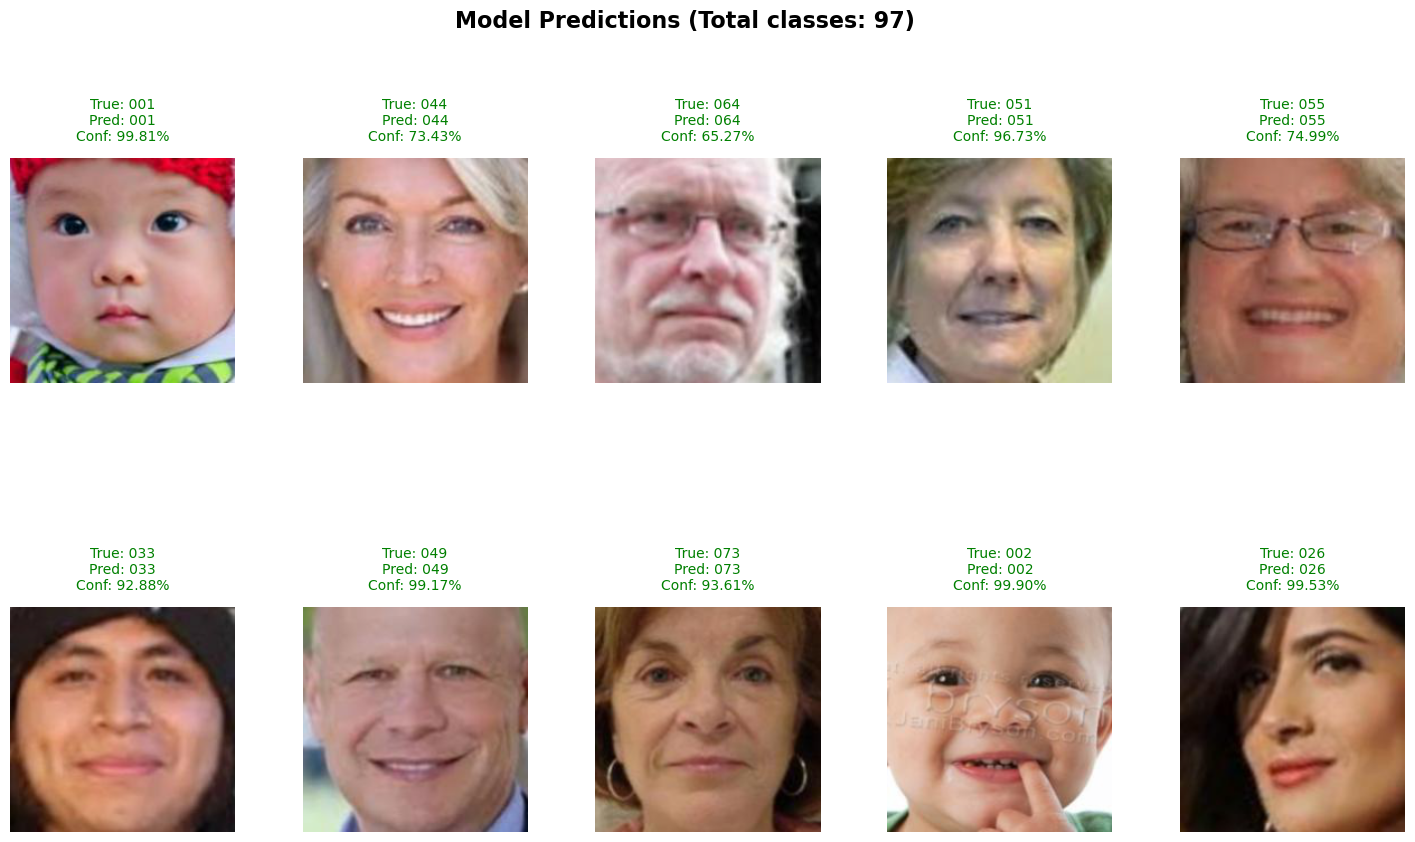

In [30]:
best_model.eval()

# Создаем список имен классов из папок
path = 'C:/Users/User/Desktop/Нейронка для чая/data_split/train'
class_names = []

for item in os.listdir(path):
    full_path = os.path.join(path, item)
    if os.path.isdir(full_path):
        class_names.append(item)

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)

with torch.no_grad():
    outputs = best_model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidences, predictions = torch.max(probabilities, 1)

images = images.cpu()
predictions = predictions.cpu()
confidences = confidences.cpu()
labels = labels.cpu()

fig = plt.figure(figsize=(18, 10))

gs = fig.add_gridspec(2, 5, hspace=0.4, wspace=0.3)

for i in range(min(10, len(images))):
    ax = fig.add_subplot(gs[i // 5, i % 5])
    
    img = images[i].numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    color = 'green' if predictions[i] == labels[i] else 'red'
    
    # Получаем имена классов
    true_label = labels[i].item()
    pred_label = predictions[i].item()
    
    if true_label < len(class_names):
        true_class = class_names[true_label]
    else:
        true_class = f"Class_{true_label}"
        
    if pred_label < len(class_names):
        pred_class = class_names[pred_label]
    else:
        pred_class = f"Class_{pred_label}"
    
    confidence = confidences[i].item()
    
    ax.set_title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2%}", 
                 color=color, fontsize=10, pad=12)
    ax.axis('off')

plt.suptitle(f"Model Predictions (Total classes: {len(class_names)})", 
             fontsize=16, y=0.98, fontweight='bold')
plt.tight_layout()
plt.show()



Модель справляется отлично. Заметно что модель верно определяет возраст человека и высокой долей уверенности. Модель сохраним для дальнейшей работы.

# Итог

Обучена с помощью transfer learning модель с accuracy 0.93. Модель представляет собой:
- Сверточная часть от resnet50, где все слои заморожены, кроме последнего;
- Классификационная часть состоит из трех полносвязных слоев, между которыми расположены Dropout и BatchNormal1ze.